![Header Image](../assets/header_image.png "Header Image")

# Assignment 1: Semantic Image Segmentation

Welcome to the assignment semantic image segmentation. In this assignment we will train a neural network to perform of the popular computer vision task __semantic image segmentation__. The task of semantic image segmentation is to assign a semantic class to every pixel of the input image, as shown in the picture below.

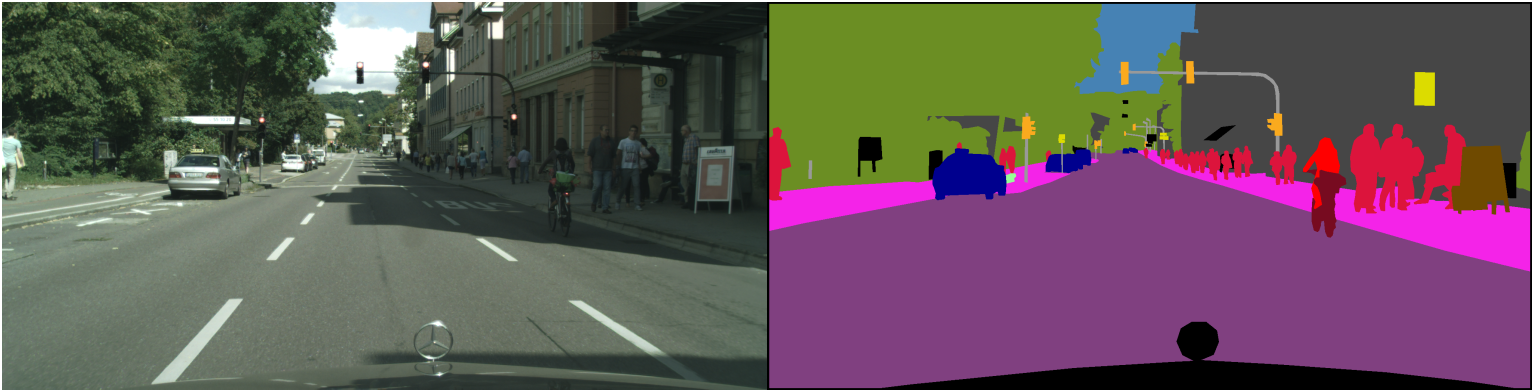

This example is of course a perfect manual annotation taken from the semantic KITTI dataset. We will use such a dataset to train a image segmentation model.

In this assignment we will walk through following steps:

- Loading a dataset for semantic image segmentation
- Convert between different label encodings of segmented images
- Creating a Tensorflow input pipeline
- Construct a deep learning model for semantic image segmentation
- Train the model and perform inference on the model

Let's start by importing all the necessary imports for this assignment:

In [ ]:
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import random
import glob

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate

from segmentation_utils.metrics import SparseMeanIoU

random.seed(123)

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)

# Dataset

For this assignment we will use the [KITTI Segmentation Dataset](http://www.cvlibs.net/datasets/kitti/eval_semseg.php?benchmark=semantics2015) which consists of 200 manually annotated images. The RGB camera images are located in the directory `datasets/kitti/image_2` and the corresponding labels are stored in directory `datasets/kitti/semantic_rgb`. This dataset will be used to train a deep learning model for the task of semantic image segmentation. Now, we will start inspecting the dataset:

In the following cell, the file paths for each image and label are extracted and lists. Then the datasets are shuffled.

In [ ]:
images_path_train = "datasets/kitti/image_2"
labels_path_train = "datasets/kitti/semantic_rgb"

# get file pathes
images_path_train = sorted(glob.glob(os.path.join(images_path_train, "*.png")))
labels_path_train = sorted(glob.glob(os.path.join(labels_path_train, "*.png")))

# shuffle the dataset
fused_list = list(zip(images_path_train, labels_path_train))
random.shuffle(fused_list)
images_path_train, labels_path_train = map(list, zip(*fused_list))

print(images_path_train[0])
print(labels_path_train[0])

We can visualize image and label with the library `matplotlib`:

In [ ]:
plt.imshow(plt.imread(images_path_train[0]))
plt.show()

plt.imshow(plt.imread(labels_path_train[0]))
plt.show()

## Color Class Association

For a better visualisation the classes of the segmented image are colorized. That means, each class is associated with a certain color. The association between the color and the classes is stored in the following dictionary. It contains the mapping from __RGB color code__ to the __class ID__. As you can see, each class corresponts also to a semantic class such as __Road__, __Sidewalk__ or __Person__.

In [ ]:
rgb_to_class_id = {
    (128, 64, 128):  0,   # Road
    (244, 35, 232):  1,   # Sidewalk
    (250, 170, 160): 2,   # Parking
    (230, 150, 140): 3,   # Tail track
    (220,  20,  60): 4,   # Person
    (255,   0,   0): 5,   # Rider
    (  0,   0, 142): 6,   # Car
    (  0,   0,  70): 7,   # Truck
    (  0,  60, 100): 8,   # Bus
    (  0,  80, 100): 9,   # On Rails
    (  0,   0, 230): 10,  # Motorcycle
    (119,  11,  32): 11,  # Bicycle
    (  0,   0,  90): 12,  # Caravan
    (  0,   0, 110): 13,  # Trailer
    ( 70,  70,  70): 14,  # Building
    (102, 102, 156): 15,  # Wall
    (190, 153, 153): 16,  # Fence
    (180, 165, 180): 17,  # Guard Rail
    (150, 100, 100): 18,  # Bridge
    ( 50, 120,  90): 19,  # Tunnel
    (153, 153, 153): 20,  # Pole
    (220, 220,   0): 21,  # Traffic sign
    (250, 170,  30): 22,  # Traffic light
    (107, 142,  35): 23,  # Vegetation
    (152, 251, 152): 24,  # Terrain
    ( 70, 130, 180): 25,  # Sky
    ( 81,   0,  81): 26,  # Ground
    (111,  74,   0): 27,  # Dynamic
    ( 20,  20,  20): 28,  # Static
    (  0,   0,   0): 29   # None
}

## Task: Convert RGB label image into a segmentation map

To convert the label RBG image into a representation that can be processed by the neural network, it is necessary to convert the __RBG encoding__ into a __segmentation map__. The following figure visualizes the different variants for representing classes for image segmentation. It is assumed that only 3 classes exist and the image size is $4x4$:

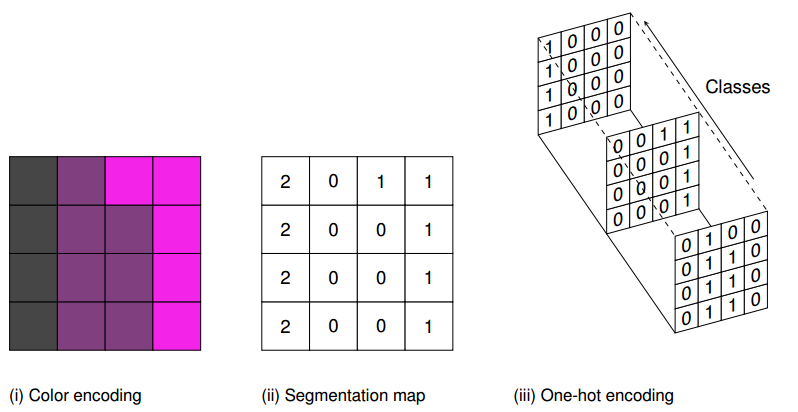

- The __color encoding__ associates each semantic class to a specific `RGB` color. It has size $4x4x3$ 
- The __segmentation map__ represents each label class with an integer from $0 ... 3$. The representation has size $4x4x1$
- The __one hot encoding__ represents each label class with an one-hot vector of size $3$. The representation has size $4x4x3$


In this assignment we will use the __segmentation map__ representation, because of it's simplicity and small footprint.

Your task is to implement the function which converts the __color encoding__ into a __segmentation map__. 

##### Replace the `None` placeholders in function `convert_rgb_encoding_to_segmentation_map` 

#### Hints
    
- Read the documentation of [tf.where](https://www.tensorflow.org/api_docs/python/tf/where) - We will use `Multiplexing between x and y`    
- `condition`: Compare the current color from the dictionary with all color occurences in the image. Use [`tf.equal()`](https://www.tensorflow.org/api_docs/python/tf/math/equal) and then [`tf.reduce_all()`](https://www.tensorflow.org/api_docs/python/tf/math/reduce_all).You will have to apply `tf.reduce_all()` on the last axis of intermediate boolean mask.
- `x` : When the condition is true, we want to write the `class_id` into the `segmentation_map`. Don't forget to cast the `class_id` to `tf.uint8` using the function `tf.cast()`
- `y` : When the condition is false, we don't want to change anything, so we will just use the `segmentation_map` 
- Use [`tf.expand_dims`](https://www.tensorflow.org/api_docs/python/tf/expand_dims) to add a dimension to a tensor. Change the shape of the tensor from [height, width] to [height, width, 1]

In [ ]:
def convert_rgb_encoding_to_segmentation_map(image, rgb_to_class_id):
    """
    Converts an image with the RGB class encoding into a class map.
    
    Argument:
    image -- tf.tensor of shape [heigh, width, 3] which contains for each pixel a tuple of (R, G, B) values.
    
    Returns:
    class_map -- tf.tensor of shape [heigh, width, 1] which contains for each pixel a single integer that represents a class
    """

    segmentation_map = tf.zeros([image.shape[0], image.shape[1]], dtype=tf.uint8)

    for color, class_id in rgb_to_class_id.items():    
    ### START CODE HERE ###
    
        segmentation_map = tf.where(
                                    condition=None,
                                    x=None,
                                    y=None
                                    )
        
    # Add dimension to change the shape from [height, width] to [height, width, 1]
    segmentation_map = None
    ### END CODE HERE ###
        
    return segmentation_map

### Test `convert_rgb_encoding_to_segmentation_map`
With the following code block you can test the funciton `convert_rgb_encoding_to_segmentation_map`. You should obtain the same picture and values as below.

In [ ]:
img = tf.image.decode_image(tf.io.read_file(labels_path_train[0]), channels=3)
img = tf.image.resize(img, [375, 1242], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
img = convert_rgb_encoding_to_segmentation_map(img, rgb_to_class_id)
y, idx = tf.unique(tf.reshape(img, -1))
print(y.numpy())


plt.imshow(img)
plt.title("Segmentation Map")
plt.show()

### Expected Output
If your implementation is correct you should see the following output and image:

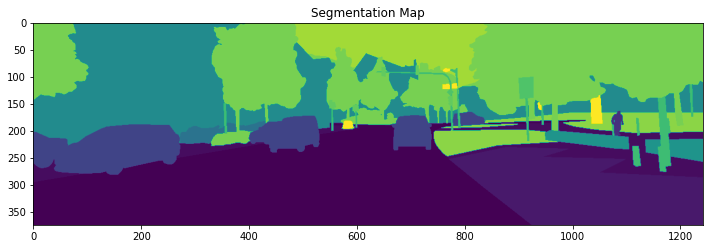

## Build TensorFlow input pipeline
In the following we will build up an efficient Tensorflow pipeline for the image segmentation dataset. We will use the [tf.data](https://www.tensorflow.org/guide/data) API for seamless interaction with the Tensorflow model that we will construct later.

## Task: Parse sample from the dataset

As you have seen above, the dataset consists of several samples. Each sample consist of an image-label pair. The function `parse_sample` processes such a sample from the dataset. It receices the path for the image and label and then decodes the `png` files. We then resize all samples to the same size, because some samples in the dataset have different sizes. Then we will apply the function `convert_rgb_encoding_to_segmentation_map` that we have implemented above.

#### Replace the `None` placeholders with your code

### Hints
- Read a file from it's file path by using [tf.io.read_file](https://www.tensorflow.org/api_docs/python/tf/io/read_file)
- Then pass this parsed file to the function [tf.image.decode_png](https://www.tensorflow.org/api_docs/python/tf/io/decode_png). Use the param `channels=3` because we are decoding a RGB image.
- Apply the function `convert_rgb_encoding_to_segmentation_map` to `label_rgb`. 


In [ ]:
def parse_sample(image_path, label_path):
    """
    Argument:
    image_path -- String which contains the path to the camera image
    label_path -- String which contains the path to the label image
    
    Returns:
    image_rgb -- tf.Tensor of size [368, 1248, 3] containing the camera image
    label_segmentation_map -- tf.Tensor of size [368, 1248, 1] containing the segmentation map
    """
    ### START CODE HERE ### 
    image_rgb = None
    label_rgb = None
    
    
    # Resize all images and labels to a uniform size, because some images in the dataset have different sizes
    image_rgb = tf.image.resize(image_rgb, [368, 1248], method=tf.image.ResizeMethod.BILINEAR)  # do not modify
    label_rgb = tf.image.resize(label_rgb, [368, 1248], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)  # do not modifly
    
    # resize returns tf.float32 for BILINEAR, convert back to tf.uint8
    image_rgb = tf.cast(image_rgb, tf.uint8) 
    
    # apply convert_rgb_encoding_to_segmentation_map to the label_rgb image
    label_segmentation_map = None
    ### END CODE HERE ###
    
    return image_rgb, label_segmentation_map

### Test `parse_sample`

In [ ]:
image, label = parse_sample(images_path_train[0], labels_path_train[0])
print("Image Shape:", image.shape)
print("Label Shape:", label.shape)
print(image[0, 0, :].numpy())
print(label[0, 0, :].numpy())

### Expected Output

## Data Normalization


Data normlization the to process to normalize the input data from an abitrary range to range $[-1, 1]$ or $[0,1 ]$. In doing so the machine learning approach often converges faster than using not normalized data.

#### Replace the `None` placeholders with your code

### Hints
- Cast the input image to `tf.float32`
- Divide the input image by `255.0`
- Note that the type of the input image is `tf.uint8` and the function should return `tf.float32`

In [ ]:
def normalize(image, label):
    """
    Normalizes the input image from range [0, 255] to [0, 1.0]
    Arguments:
    image -- tf.tensor representing a RGB image with integer values in range [0, 255] 
    label -- tf.tensor representing the corresponding segmentation mask
    
    Returns:
    image -- tf.tensor representing a RGB image with integer values in range [0, 1] 
    label -- tf.tensor representing the corresponding segmentation mask
    """
    image = None
    
    return image, label

### Test `normalize`

In [ ]:
image, label = parse_sample(images_path_train[0], labels_path_train[0])

print("Not Normalized - Maximum:", np.max(image.numpy()))
print("Not Normalized - Minimum:", np.min(image.numpy()))

image, label = normalize(image, label)

print("Normalized - Maximum", np.max(image.numpy()))
print("Normalized - Minimum", np.min(image.numpy()))

### Expected Output

## Task: Dataset creation 
The [tf.data API](https://www.tensorflow.org/guide/data) allows to build efficient data pipelines for our training. It uses the class [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) class. Such a dataset object can then be later used for training the model. The dataset pipeline runs through the following steps:

- Create `tf.data.Dataset` object from the list of strings. Use the function [tf.data.Dataset.from_tensor_slices](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices)
- Shuffle this dataset using class function [shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle). Set the `buffer_size` for the shuffeling.
- Apply the function `parse_sample` to each sample using class function [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map). Use the parameter `num_parallel_calls` and set it to `tf.data.AUTOTUNE`
- Apply the function `normalize` to each parsed sample using class function [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map). Use the parameter `num_parallel_calls` and set it to `tf.data.AUTOTUNE`
- Batch the dataset using class function [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and use the parameter `batch_size`
- Prefetch the dataset for higher pipeline throughput using class function [prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch). Use `tf.data.AUTOTUNE` for buffer_size

In [ ]:
def create_dataset(images_path, labels_path, batch_size=4, buffer_size=200):
    """
    Arguments:
    images_path -- List of Strings which contain pathes for the camera images
    labels_pathh -- List of Strings which contain pathes for the label images
    
    Returns:
    dataset -- tf.data.Dataset
    """
    
    ### START CODE HERE ### 
    # Create tf.data.Dataset from images_path and labels_path, replace both None placeholders
    dataset = tf.data.Dataset.from_tensor_slices((None, None))
    # Shuffle the dataset with buffer_size
    dataset = None
    # Apply the parse_sample function. Use tf.data.AUTOTUNE for the number of parallel calls
    dataset = None
    # Apply data normalization. Use tf.data.AUTOTUNE for the number of parallel calls
    dataset = None
    # Apply batching to the dataset using batch_size
    dataset = None
    # Use prefetching 
    dataset = None
    ### END CODE HERE ###
    return dataset

### Test `create_dataset`

In [ ]:
test_dataset = create_dataset(images_path_train, labels_path_train)
length = tf.data.experimental.cardinality(test_dataset).numpy()

print(test_dataset)
print("Length:", length)

### Expected Output

Note that the length of the dataset has decreased to 50 due to batching with batch size 4.

## Task: Create Train Val Split

For our training, we would like to split the dataset into a __train__ set and __val__ set.

- The __train__ set should contain 70 % of the data
- The __val__ set should contain 30 % of the data

Compute the number of samples for the train set

In [ ]:
# get number of data samples
length = len(images_path_train)

### START CODE HERE ### 
train_size = None
### END CODE HERE ###

Now, we know the `train_size` and we can apply it to class functions `take` and `skip` to split the dataset into `train` and `val` dataset

In [ ]:
train = create_dataset(images_path_train[:train_size], labels_path_train[:train_size])
val = create_dataset(images_path_train[train_size:], labels_path_train[train_size:])

### Test Train Val split sizes

In [ ]:
print("Train Dataset Length:", tf.data.experimental.cardinality(train).numpy())
print("Val Dataset Length:", tf.data.experimental.cardinality(val).numpy())

### Expected Output

# Model Architecture

In this assignment we will use the U-Net architecture for the task of semantic image segmentation. It was originally developed for medical image analysis, but we will use this easy-to-train architecture here in our assignment. We do not require you to construct or programm any lowlevel parts of this architecture, but you are free to read the following code and try to understand how this model is constructed. We will later use the functions `encoder()` and `decoder()` to assemble the network. In case you are interested about the particular architecture, feel free to read the corresponding [paper](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).

In [ ]:
def encoder(input,
            udepth,
            filters1,
            kernel_size,
            activation,
            batch_norm,
            dropout):

    t = input
    encoder_layers = udepth * [None]

    # layer creation with successive pooling
    for d in range(udepth):
        filters = (2**d) * filters1
        t = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding="same",
                   activation=activation)(t)
        t = BatchNormalization()(t) if batch_norm else t
        t = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding="same",
                   activation=activation)(t)
        t = encoder_layers[d] = BatchNormalization()(t) if batch_norm else t
        if d < (udepth - 1):
            t = MaxPooling2D(pool_size=(2, 2), padding="same")(t)
            t = Dropout(rate=dropout)(t) if dropout > 0 else t

    return encoder_layers


def decoder(encoder_layers,
            udepth,
            filters1,
            kernel_size,
            activation,
            batch_norm,
            dropout):

    # start at lowest encoder layer
    t = encoder_layers[udepth - 1]

    # layer expansion symmetric to encoder
    for d in reversed(range(udepth - 1)):
        filters = (2**d) * filters1
        t = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=(2, 2),
                            padding="same")(t)

        t = Concatenate()([encoder_layers[d], t])
        t = Dropout(rate=dropout)(t) if dropout > 0 else t
        t = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding="same",
                   activation=activation)(t)
        t = BatchNormalization()(t) if batch_norm else t
        t = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding="same",
                   activation=activation)(t)
        t = BatchNormalization()(t) if batch_norm else t

    return t

## Task: Assemble the U-Net segmentation model

To construct the whole model, we will use the encoder part and decoder part of the network and connect them with each other. We will also have to define an input layer and some output operations. Your task is to replace the `None` placeholders in the function `getModel()`. Read the hints carefully to fullfill this task. 

### Hints
- Create a Keras [Input](https://www.tensorflow.org/api_docs/python/tf/keras/Input) Layer with an input shape equal to `input_shape`
- Use the encoder function from above to constuct the `encoder_layers`. Pass all necessary arguments to the function call and use `input_tensor` as input
- Use the decoder function from above to construct the `reconstruction`. Pass all necessary arguments to the function call und use the previously `encoder_layers` as input to the function
- The final prediction layer must have an output shape of [height, width, num_classes]. That can be achieved by setting the `filters` param of the `Conv2D` opertation equal to `num_classes`. Feed the layer with the `reconstruction` from above. Make use of the [Keras functional API](https://keras.io/guides/functional_api/)
- Apply `Activation("Softmax")` to the computed `logits` in order to obtain scaled probabilities. Make use of the [Keras functional API](https://keras.io/guides/functional_api/)
- Create Keras `Model` where `inputs` corresponts to the `input_tensor` placeholder and `outputs` to the `probabilities`. This Keras model can be created with `Model(inputs= ..., outputs= ...)`


In [ ]:
def getModel(input_shape,
             num_classes,
             udepth=5,
             filters1=16,
             kernel_size=(3, 3),
             activation=tf.nn.relu,
             batch_norm=True,
             dropout=0.1):
    """
    This function assembles the U-Net architecture and returns a Keras model which can be trained, saved and loaded.
    
    Arguments:
    input_shape -- Input shape of the model as tuple or list
    num_classes -- Number of classes to predict as int
    udepth -- Depth of the network
    filters1 -- Number of filters at the first layer
    kernel_size -- Kernel size for the convolutional operations
    activation -- Type of the Activation function
    batch_norm -- Boolean if batch norm should be applied
    dropout -- Dropout regularization  
    
    Returns:
    segmentation_model -- Keras Model
    """
    
    ### START CODE HERE ### 
    
    # create input layer
    input_tensor = None

    # construct encoder
    encoder_layers = encoder(input=None,
                             udepth=None,
                             filters1=None,
                             kernel_size=None,
                             activation=None,
                             batch_norm=None,
                             dropout=None
                            )

    # construct decoder
    reconstruction = decoder(encoder_layers=None,
                             udepth=None,
                             filters1=None,
                             kernel_size=None,
                             activation=None,
                             batch_norm=None,
                             dropout=None
                            )

    # build final prediction layer
    logits = Conv2D(filters=None,
                    kernel_size=kernel_size,
                    padding="same",
                    activation=activation)(None)
    
    # apply softmax activation function to the logits 
    probabilities = None
    
    # create a Keras model
    segmentation_model = Model(inputs=None, outputs=None)
    
    ### END CODE HERE ###
    
    return segmentation_model

### Test: `getModel`

In [ ]:
model = getModel(input_shape=[368, 1248, 3], num_classes=30)

print(model.summary())

#### Expected Output
You should obtain a summary output similar to this one. Beware, that this test does not guarantee that you have set all parameters correctly.

# Model training

Once our model is setup up correctly we can compile it by adding an __optimizer__ to the model, a __loss function__ and we can also add more __metrics__ in order to observe the training progress.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=[SparseMeanIoU(num_classes=30, name="MIoU")])

Now, the training of the model can be evoked by calling the class function `fit`. Note that we will train here only 1 epoch for demonstration. We don't want you to wait several hours for the model to finish. We will use in the next steps a pretrained model which was trained for several hundred steps.

In [ ]:
history = model.fit(train, validation_data=val, epochs=1)

### Expected Output

# Model Loading

The pretrained model can be loaded into the existing model by using the function `load_weights`. This model was trained much longer than in this excercise. Hence the performance is much better and we will use this model for the next tasks.

In [ ]:
model.load_weights("segmentation_utils/pretrained_model/model")

# Model inference

We can now perform __inference__ on that pretrained model by loading a sample from the dataset and use the model's `predict` function.

In [ ]:
image, label = parse_sample(images_path_train[-1], labels_path_train[-1])
image, label = normalize(image, label)

# add batch dimension
image = tf.expand_dims(image, axis=0)

probabilities = model.predict(image)

print("Input Image Shape:  ", image.shape)
print("Probabilities Shape:", probabilities.shape)

### Task: Compute segmentation map from one-hot-encoding
As you can see, the prediction of the network has shape `[batch_size, height, width, num_classes]`. That means we have for each pixel an one-hot encoding vector of length 30. The one-hot-encoding vector represents the probabilities for each class per pixel. In order to compute the segmentation map we have to take the class with the highest probaility.

#### Hints
- Use function `tf.argmax` to determine the classes with highest probaility. You will need to specify the `axis` argument. You want to reduce the shape from `[batch_size, height, width, num_classes]` to `[batch_size, height, width, 1]`. So which dimension do you have to reduce ?
- Get rid of the batch dimension in order to use the plot functions. In our case, the batch size is only one. Hence, the size is `[1, height, width, 1]`. Use `tf.squeeze` to remove unecessary dimensions.

In [ ]:
### START CODE HERE ### 
# compute the segmentation map
prediction = None
# get rid of the batch dimension
prediction = None
### END CODE HERE ###

### Test: Compute segmentation map

In [ ]:
print("Prediction shape:", prediction.shape)

### Expected Output

### Plot of the segmentation map
Now we can simply use matplotlib's `imshow` function to visualize the predictions and the label.

In [ ]:
plt.figure()
plt.imshow(prediction)
plt.title("Segmentation Map Prediction")
plt.show()

plt.figure()
plt.imshow(label)
plt.title("Segmentation Map Label")
plt.show()

### Task: Apply Class-Color Association 
You may remeber that at the beginning we transformed the __RGB encoding__ into a __segmentation map__. Now we want to perform the same operation in reverse ! We want to convert the __segmentation map__ into the __RGB encoding__ for a nicer visualization.

Replace the `None` placeholders in function `segmentation_map_to_rgb_encoding`!

#### Hints
- Iterate over the key - values pairs in the dictionary `rgb_to_class_id` using [`items()`](https://www.w3schools.com/python/ref_dictionary_items.asp)
- Use numpy [index assignment](https://numpy.org/doc/stable/user/basics.indexing.html) to assign the color values to the output image `rgb_encoding`
- When the current `class_id` is equal to some values in `segmentation map`, assign the current color to these specific positions in `rgb_encoding` 

In [ ]:
def segmentation_map_to_rgb_encoding(segmentation_map, rgb_to_class_id):
    """
    Converts the segmentation map into a RGB encoding
    
    Arguments:
    segmentation_map -- Numpy ndArray of shape [height, width, 1]
    rgb_to_class_id -- Dictionary which contains the association between color and class ID
    
    Returns:
    rgb_encoding -- Numpy ndArray of shape [height, width, 3]
    """

    rgb_encoding = np.zeros([segmentation_map.shape[0], segmentation_map.shape[1], 3], dtype=np.uint8)
    
    ### START CODE HERE ### 
    for color, class_id in None:
        
        rgb_encoding[None==None] = None
    
    ### END CODE HERE ###
    return rgb_encoding

### Test: `segmentation_map_to_rgb_encoding`

In [ ]:
rgb_encoding = segmentation_map_to_rgb_encoding(prediction, rgb_to_class_id)

print("RGB Encoding shape:", rgb_encoding.shape)

plt.figure(figsize=(12, 12))
plt.imshow(rgb_encoding)
plt.title("RGB Encoding Prediction")
plt.show()


rgb_encoding = segmentation_map_to_rgb_encoding(np.squeeze(label), rgb_to_class_id)

plt.figure(figsize=(12, 12))
plt.imshow(rgb_encoding)
plt.title("RGB Encoding Label")
plt.show()

### Expected Output

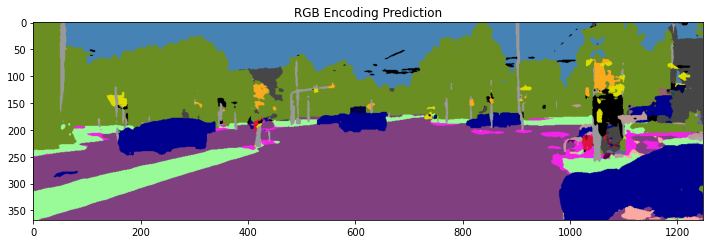

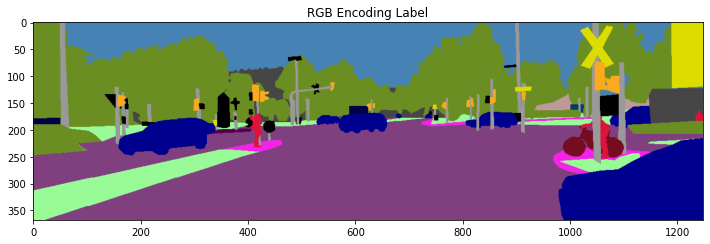

Gratulations! You finished the Assignment `Semantic Image Segmentation`

# Wrap Up
- You learned about semantic image segmentation using a deep learning approach
- You learned about different encodings to represent a segmantically segmented image
- You learned how to set up a Tensorflow Dataset pipeline
- You learned how to train a U-Net architecture for semantic image segmentation

# References

#### Kitti Dataset

U-Net Architecture

## License

MIT License

Copyright 2023 Institute for Automotive Engineering of RWTH Aachen University.